In [2]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import math

In [3]:
path = "./"
!rm -rf "./pictures"
!rm -rf "./blurred_pictures"
!mkdir pictures
!mkdir blurred_pictures

NUMBER_OF_PLATES = 10000

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", 200)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)
    resized = cv2.resize(blank_plate, (300,80))

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             resized)

In [4]:
PATH = "./pictures/"
labels = os.listdir(PATH)
print(len(labels))

9300


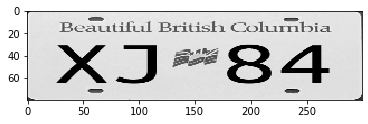

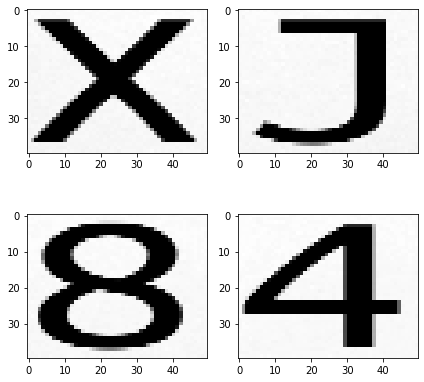

In [5]:
img = cv2.cvtColor(cv2.imread(f"./pictures/{labels[0]}"), cv2.COLOR_BGR2GRAY)
# img = cv2.GaussianBlur(img, (31,31), 0)

x0,y,w,h = 25, 28, 50, 40
x1 = 75
x2 = 176
x3 = 226
plt.imshow(img, cmap='gray')
characters = []
characters.append(img[y:y+h, x0:x0+w])
characters.append(img[y:y+h, x1:x1+w])
characters.append(img[y:y+h, x2:x2+w])
characters.append(img[y:y+h, x3:x3+w])

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Plot the smaller images in the remaining subplots
for i, ax in enumerate(axs.flatten()):
    ax.imshow(characters[i], cmap='gray')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
##Augment the data
#Blur each plate with a random kernel (1,1) to (31,31)
#size must be an odd number
for i in range(0, len(labels)):
    n = randint(0,15)
    img = cv2.cvtColor(cv2.imread(f"{PATH+labels[i]}"), cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(img, (2*n+1,2*n+1), 0)
    cv2.imwrite(os.path.join("./blurred_pictures/",labels[i]), blurred)



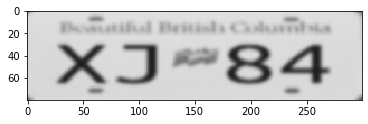

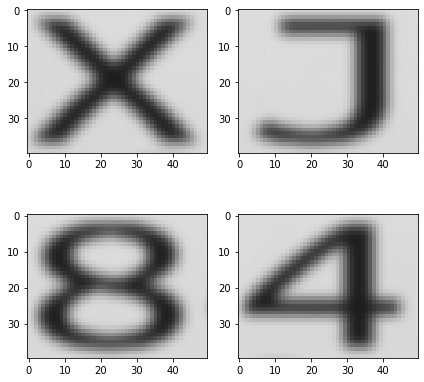

In [7]:
img = cv2.imread(f"./blurred_pictures/{labels[0]}")

x0,y,w,h = 25, 28, 50, 40
x1 = 75
x2 = 176
x3 = 226
plt.imshow(img, cmap='gray')
characters = []
characters.append(img[y:y+h, x0:x0+w])
characters.append(img[y:y+h, x1:x1+w])
characters.append(img[y:y+h, x2:x2+w])
characters.append(img[y:y+h, x3:x3+w])

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Plot the smaller images in the remaining subplots
for i, ax in enumerate(axs.flatten()):
    ax.imshow(characters[i], cmap='gray')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
data = []

for label in labels:
    img = cv2.cvtColor(cv2.imread(f"{PATH+label}"), cv2.COLOR_BGR2GRAY)
    x0,y,w,h = 25, 28, 50, 40
    x1 = 75
    x2 = 176
    x3 = 226
    CLASSES = 36
    # data.append(((img[y:y+h, x0:x0+w]), ord(label[6])-65))
    # data.append(((img[y:y+h, x1:x1+w]), ord(label[7])-65))
    # data.append(((img[y:y+h, x2:x2+w]), ord(label[8])-48+26))
    # data.append(((img[y:y+h, x3:x3+w]), ord(label[9])-48+26))

    data.append(((img[y:y+h, x0:x0+w]), np.identity(CLASSES)[ord(label[6])-65].reshape(CLASSES)))
    data.append(((img[y:y+h, x1:x1+w]), np.identity(CLASSES)[ord(label[7])-65].reshape(CLASSES)))
    data.append(((img[y:y+h, x2:x2+w]), np.identity(CLASSES)[ord(label[8])-48+26].reshape(CLASSES)))
    data.append(((img[y:y+h, x3:x3+w]), np.identity(CLASSES)[ord(label[9])-48+26].reshape(CLASSES)))

In [9]:
VALIDATION_SPLIT = 0.2

X_dataset = np.array([x[0] for x in data])
Y_dataset = np.array([x[1] for x in data])

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

X shape: (37200, 40, 50)
Y shape: (37200, 36)
Total examples: 37200
Training examples: 29760
Validation examples: 7440


In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [11]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [12]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(40, 50, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))


# conv_model = models.Sequential()
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(40, 50, 1))) #3 for bgr, 1 for grayscale 144, 256 for 20%
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# # conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# # conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(64, activation='relu'))
# conv_model.add(layers.Dense(64, activation='relu'))
# conv_model.add(layers.Dense(64, activation='relu'))
# conv_model.add(layers.Dense(36, activation='softmax'))

In [13]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 22, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 10, 128)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 8, 128)         1

In [14]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [15]:
reset_weights(conv_model)

/home/fizzer/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [17]:
history_conv = conv_model.fit(X_train_dataset, Y_train_dataset, 
                              validation_data=(X_val_dataset, Y_val_dataset), 
                              epochs=5, 
                              batch_size=16)

# We can also run the training by specifiying the validation split directly.
# history_conv = conv_model.fit(X_dataset, Y_dataset, 
#                               validation_split=VALIDATION_SPLIT, 
#                               epochs=80, 
#                               batch_size=16)

Epoch 1/5
1860/1860 [==============================] - 39s 21ms/step - loss: 0.0039 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
1860/1860 [==============================] - 41s 22ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
1860/1860 [==============================] - 40s 22ms/step - loss: 2.1627e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
1860/1860 [==============================] - 42s 22ms/step - loss: 5.3749e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
1860/1860 [==============================] - 41s 22ms/step - loss: 6.3341e-04 - acc: 0.9999 - val_loss: 0.0000e+00 - val_acc: 1.0000


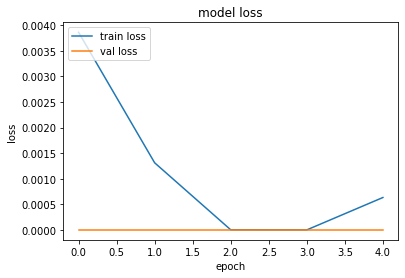

In [18]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

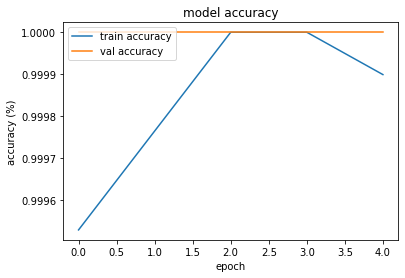

In [20]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
ypred = conv_model.predict(X_val_dataset)
ypred=np.argmax(ypred, axis=1)
ytest=np.argmax(Y_val_dataset, axis=1)

233/233 [==============================] - 3s 13ms/step


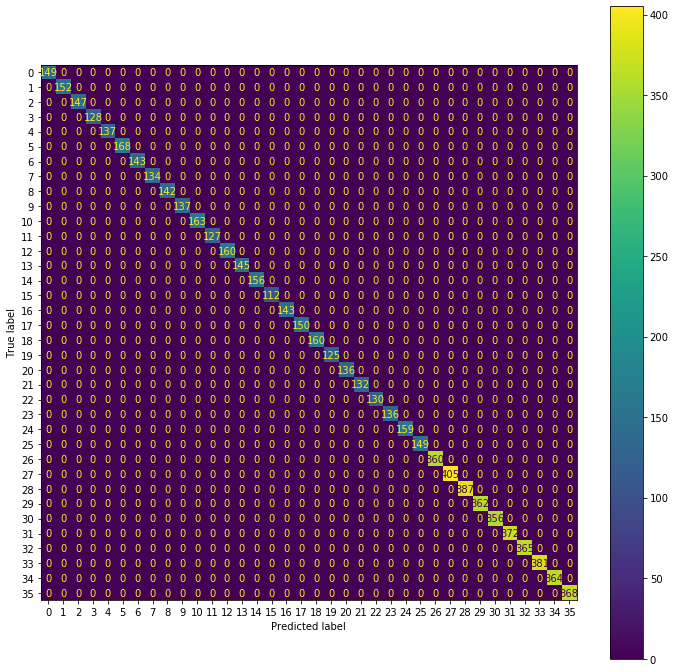

In [22]:
disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred)
fig = disp.figure_
fig.set_figwidth(12)
fig.set_figheight(12) 
plt.show()

# Getting Chars from Driving Data

In [47]:
# IMAGE_PATH = "/content/drive/MyDrive/ENPH 353/Competition/Plates/"
IMAGE_PATH = "../media/Plates/"
filenames = os.listdir(IMAGE_PATH)

filename_list = []
for filename in filenames:
    if os.path.isfile(os.path.join(IMAGE_PATH, filename)):
        filename_list.append(filename)

char_upper_hsv = np.array([121,255,255])
char_lower_hsv = np.array([118,38,88])

In [48]:
plates =[]
for filename in filename_list:
    image = cv2.imread(f"{IMAGE_PATH+filename}")
    #image = get_grayscale_image(filename)
    plates.append(image)

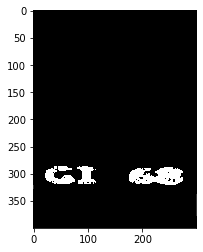

In [49]:
result = plates[0]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
hsv_result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
result_mask = cv2.inRange(hsv_result, char_lower_hsv, char_upper_hsv)
plt.imshow(result_mask, cmap='gray')
cv2.morphologyEx(result_mask, cv2.MORPH_OPEN, (5,5), result_mask, iterations=2)
plt.imshow(result_mask, cmap='gray')

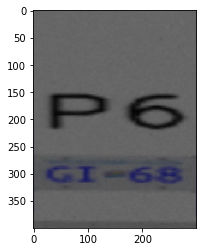

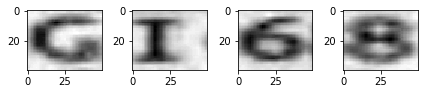

In [50]:
result = plates[0]
threshold = 120
hsv_result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
result_mask = cv2.inRange(hsv_result, char_lower_hsv, char_upper_hsv)
cv2.morphologyEx(result_mask, cv2.MORPH_OPEN, (5,5), result_mask, iterations=2)
contours, _ = cv2.findContours(result_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

bounding_boxes = []
for c in contours:
                    if cv2.contourArea(c) > 300:
                        (x, y, w, h) = cv2.boundingRect(c)
                        #cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 255), 2)
                        bounding_boxes.append((x, y, w, h))
                        #total_area += w*h
# for c in contours:
#   if cv2.contourArea(c) < 5000 and cv2.contourArea(c) > 100:
#     cv2.drawContours(result, c, -1, (0, 255, 0), 3)
bounding_boxes.sort(key=lambda x: x[0], reverse=False)
chars = []

for box in bounding_boxes:
  if box[2] > 60:
    chars.append(cv2.cvtColor(result[box[1]-5: box[1]+35, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))
    chars.append(cv2.cvtColor(result[box[1]-5: box[1]+35, box[0]+box[2]//2: box[0]+box[2]//2+50], cv2.COLOR_BGR2GRAY))
    pass
  else:
    chars.append(cv2.cvtColor(result[box[1]-5: box[1]+35, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))


plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# print(chars)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(6, 6))
# Plot the smaller images in the remaining subplots
for i, ax in enumerate(axs.flatten()):
    ax.imshow(chars[i], cmap='gray')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot

In [51]:
threshold = 120
def get_chars_from_image(filename):
  result = cv2.imread(f"{IMAGE_PATH+filename}")
  hsv_result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
  result_mask = cv2.inRange(hsv_result, char_lower_hsv, char_upper_hsv)
  cv2.morphologyEx(result_mask, cv2.MORPH_OPEN, (5,5), result_mask, iterations=2)
  contours, _ = cv2.findContours(result_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)

  bounding_boxes = []
  for c in contours:
                      if cv2.contourArea(c) > 300:
                          (x, y, w, h) = cv2.boundingRect(c)
                          #cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 255), 2)
                          bounding_boxes.append((x, y, w, h))
                          #total_area += w*h
  # for c in contours:
  #   if cv2.contourArea(c) < 5000 and cv2.contourArea(c) > 100:
  #     cv2.drawContours(result, c, -1, (0, 255, 0), 3)
  bounding_boxes.sort(key=lambda x: x[0], reverse=False)
  chars = []

  for box in bounding_boxes:
    if box[2] > 60:
      chars.append(cv2.cvtColor(result[box[1]: box[1]+40, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))
      chars.append(cv2.cvtColor(result[box[1]: box[1]+40, box[0]+box[2]//2: box[0]+box[2]//2+50], cv2.COLOR_BGR2GRAY))
      pass
    else:
      chars.append(cv2.cvtColor(result[box[1]: box[1]+40, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))
  return chars

In [52]:
training_data = []
CLASSES = 36
for filename in filename_list:
    chars = get_chars_from_image(filename)
    if (len(chars) == 4 and chars[3].shape == (40, 50)): #needs to be more robust
      training_data.append((chars[0], np.identity(CLASSES)[ord(filename[2])-65].reshape(CLASSES)))
      training_data.append((chars[1], np.identity(CLASSES)[ord(filename[3])-65].reshape(CLASSES)))
      training_data.append((chars[2], np.identity(CLASSES)[ord(filename[4])-48+26].reshape(CLASSES)))
      training_data.append((chars[3], np.identity(CLASSES)[ord(filename[5])-48+26].reshape(CLASSES)))
      if chars[3].shape != (40, 50):
        print(filename)
    


3768
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


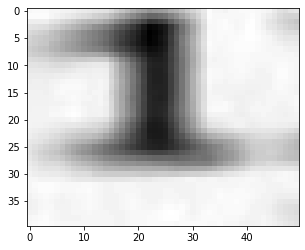

In [56]:
print(len(training_data))
plt.imshow(training_data[6][0], cmap='gray')
print(training_data[6][1])

In [57]:
# Shuffle the data
random.shuffle(training_data)

In [64]:
#Generate X and Y datasets
X_dataset = np.array([char[0] for char in training_data])

In [65]:
Y_dataset = np.array([state_pair[1] for state_pair in training_data])

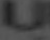

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
cv2_imshow(X_dataset[200])
print(Y_dataset[200])

## CNN Setup

In [66]:
VALIDATION_SPLIT = 0.1 # 10% of the dataset is for validation

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

#splitting the datasets
X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

X shape: (3768, 40, 50)
Y shape: (3768, 36)
Total examples: 3768
Training examples: 3392
Validation examples: 376


In [ ]:
#%tensorflow_version 2.9
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [ ]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [ ]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(40, 50, 1))) #3 for bgr, 1 for grayscale 144, 256 for 20%
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

In [ ]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 11, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 4, 128)        0

In [ ]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [67]:
history_conv = conv_model.fit(X_train_dataset, Y_train_dataset, 
                              validation_data=(X_val_dataset, Y_val_dataset), 
                              epochs=40, 
                              batch_size=16)

Epoch 1/40
212/212 [==============================] - 4s 17ms/step - loss: 0.9037 - acc: 0.7830 - val_loss: 0.2947 - val_acc: 0.9415
Epoch 2/40
212/212 [==============================] - 4s 17ms/step - loss: 0.3464 - acc: 0.9301 - val_loss: 0.2505 - val_acc: 0.9601
Epoch 3/40
212/212 [==============================] - 4s 17ms/step - loss: 0.2444 - acc: 0.9434 - val_loss: 0.2704 - val_acc: 0.9628
Epoch 4/40
212/212 [==============================] - 4s 17ms/step - loss: 0.2266 - acc: 0.9537 - val_loss: 0.2174 - val_acc: 0.9761
Epoch 5/40
212/212 [==============================] - 4s 18ms/step - loss: 0.1889 - acc: 0.9587 - val_loss: 0.2268 - val_acc: 0.9814
Epoch 6/40
212/212 [==============================] - 4s 18ms/step - loss: 0.1549 - acc: 0.9673 - val_loss: 0.2716 - val_acc: 0.9761
Epoch 7/40
212/212 [==============================] - 4s 18ms/step - loss: 0.1386 - acc: 0.9696 - val_loss: 0.2463 - val_acc: 0.9787
Epoch 8/40
212/212 [==============================] - 4s 18ms/step - 

In [ ]:
from keras.models import load_model

In [68]:
conv_model.save('Chars_model_V2.h5')

In [ ]:
from google.colab import files
files.download("Chars_model_V1.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

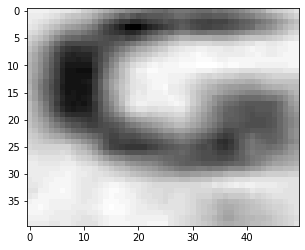

In [69]:
all_chars = []
for filename in filename_list:
    all_chars.append(get_chars_from_image(filename))

plt.imshow(all_chars[0][0], cmap='gray')
plt.show()


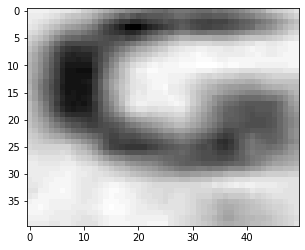

1/1 [==============================] - 0s 20ms/step
6


In [70]:
all_chars = []
for filename in filename_list:
    all_chars.append(get_chars_from_image(filename))

plt.imshow(all_chars[0][0], cmap='gray')
plt.show()

print(np.argmax(conv_model.predict(all_chars[0][0].reshape(1, 40, 50, 1))))